This notebook sets up the workflow for the various functions we have implemented. It shows an example of how we clustered using Nonnegative Matrix Factorization. We manually inspect the output of NMF to determine the best number of clusters for each group

In [1]:
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from utils.clean_up import *
from utils.categorize_demographics import *
from utils.nonnegative_matrix_factorization import nmf_inspect, nmf_labels

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
mpl.rc('savefig', dpi=200)
params = {'figure.dpi' : 200,
          'figure.figsize' : (16, 12),
          'axes.axisbelow' : True,
          'lines.antialiased' : True,
          'axes.titlesize' : 'xx-large',
          'axes.labelsize' : 'x-large',
          'xtick.labelsize' : 'large',
          'ytick.labelsize' : 'large',
          'legend.fontsize' : 'x-large'}

for (k, v) in params.items():
    plt.rcParams[k] = v

In [3]:
essay_dict = {'essay0' : 'My self summary',
              'essay1' : 'What I\'m doing with my life',
              'essay2' : 'I\'m really good at',
              'essay3' : 'The first thing people notice about me',
              'essay4' : 'Favorite books, movies, tv, food',
              'essay5' : 'The six things I could never do without',
              'essay6' : 'I spend a lot of time thinking about',
              'essay7' : 'On a typical Friday night I am',
              'essay8' : 'The most private thing I am willing to admit',
              'essay9' : 'You should message me if'}

Getting the data, cleaning it, and categorizing demographic data

In [4]:
df = pd.read_csv('data/profiles.20120630.csv')

In [5]:
essay_list = ['essay4']
df_clean = clean_up(df, essay_list)

In [6]:
df_clean.shape

(48105, 32)

In [7]:
df_clean.fillna('', inplace=True)

In [8]:
df_clean['religion'] = df_clean['religion'].apply(religion_categories)
df_clean['job'] = df_clean['job'].apply(job_categories)
df_clean['drugs'] = df_clean['drugs'].apply(drug_categories)
df_clean['diet'] = df_clean['diet'].apply(diet_categories)
df_clean['body_type'] = df_clean['body_type'].apply(body_categories)
df_clean['drinks'] = df_clean['drinks'].apply(drink_categories)
df_clean['sign'] = df_clean['sign'].apply(sign_categories)
df_clean['ethnicity'] = df_clean['ethnicity'].apply(ethnicity_categories)
df_clean['pets'] = df_clean['pets'].apply(pets_categories)
df_clean['speaks'] = df_clean['speaks'].apply(language_categories)

In [9]:
count_matrix, tfidf_matrix, vocab = col_to_data_matrix(df_clean, essay_list[0])

In [10]:
K = 25

In [11]:
nmf_inspect(tfidf_matrix, vocab, k_vals=[K], n_words=50)

25
Group 0:
i'm | fan | reading | pretty | food i'm | i've | i'm big | right | i'm reading | big | currently | music i'm | i'm pretty | open | huge | big fan | it's | picky | right i'm | i'm currently | i'm really | listening | books i'm | going | sucker | i'm sucker | really | trying | comes | i'll | ... i'm | currently reading | foodie | sure | usually | reader | probably | stuff | bit | i'd | eater | vegetarian | cook | lately | far | working | listen | that's | place | tastes

Group 1:
development | arrested | arrested development | 30 | 30 rock | sunny | parks | rock | it's sunny | sunny philadelphia | philadelphia | it's | office | it's sunny philadelphia | rec | parks rec | tv | recreation | community | parks recreation | curb | curb enthusiasm | enthusiasm | shows | wire | seinfeld | daily | archer | dexter | colbert | report | colbert report | breaking | breaking bad | daily colbert | bad | park | party | firefly | league | daily colbert report | futurama | tv shows | louie | 

In [12]:
df_clean['group'] = nmf_labels(tfidf_matrix, k=K)

In [13]:
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821',
          '#D55E00', '#CC79A7', '#56B4E9', '#009E73',
          '#F0E442', '#0072B2']

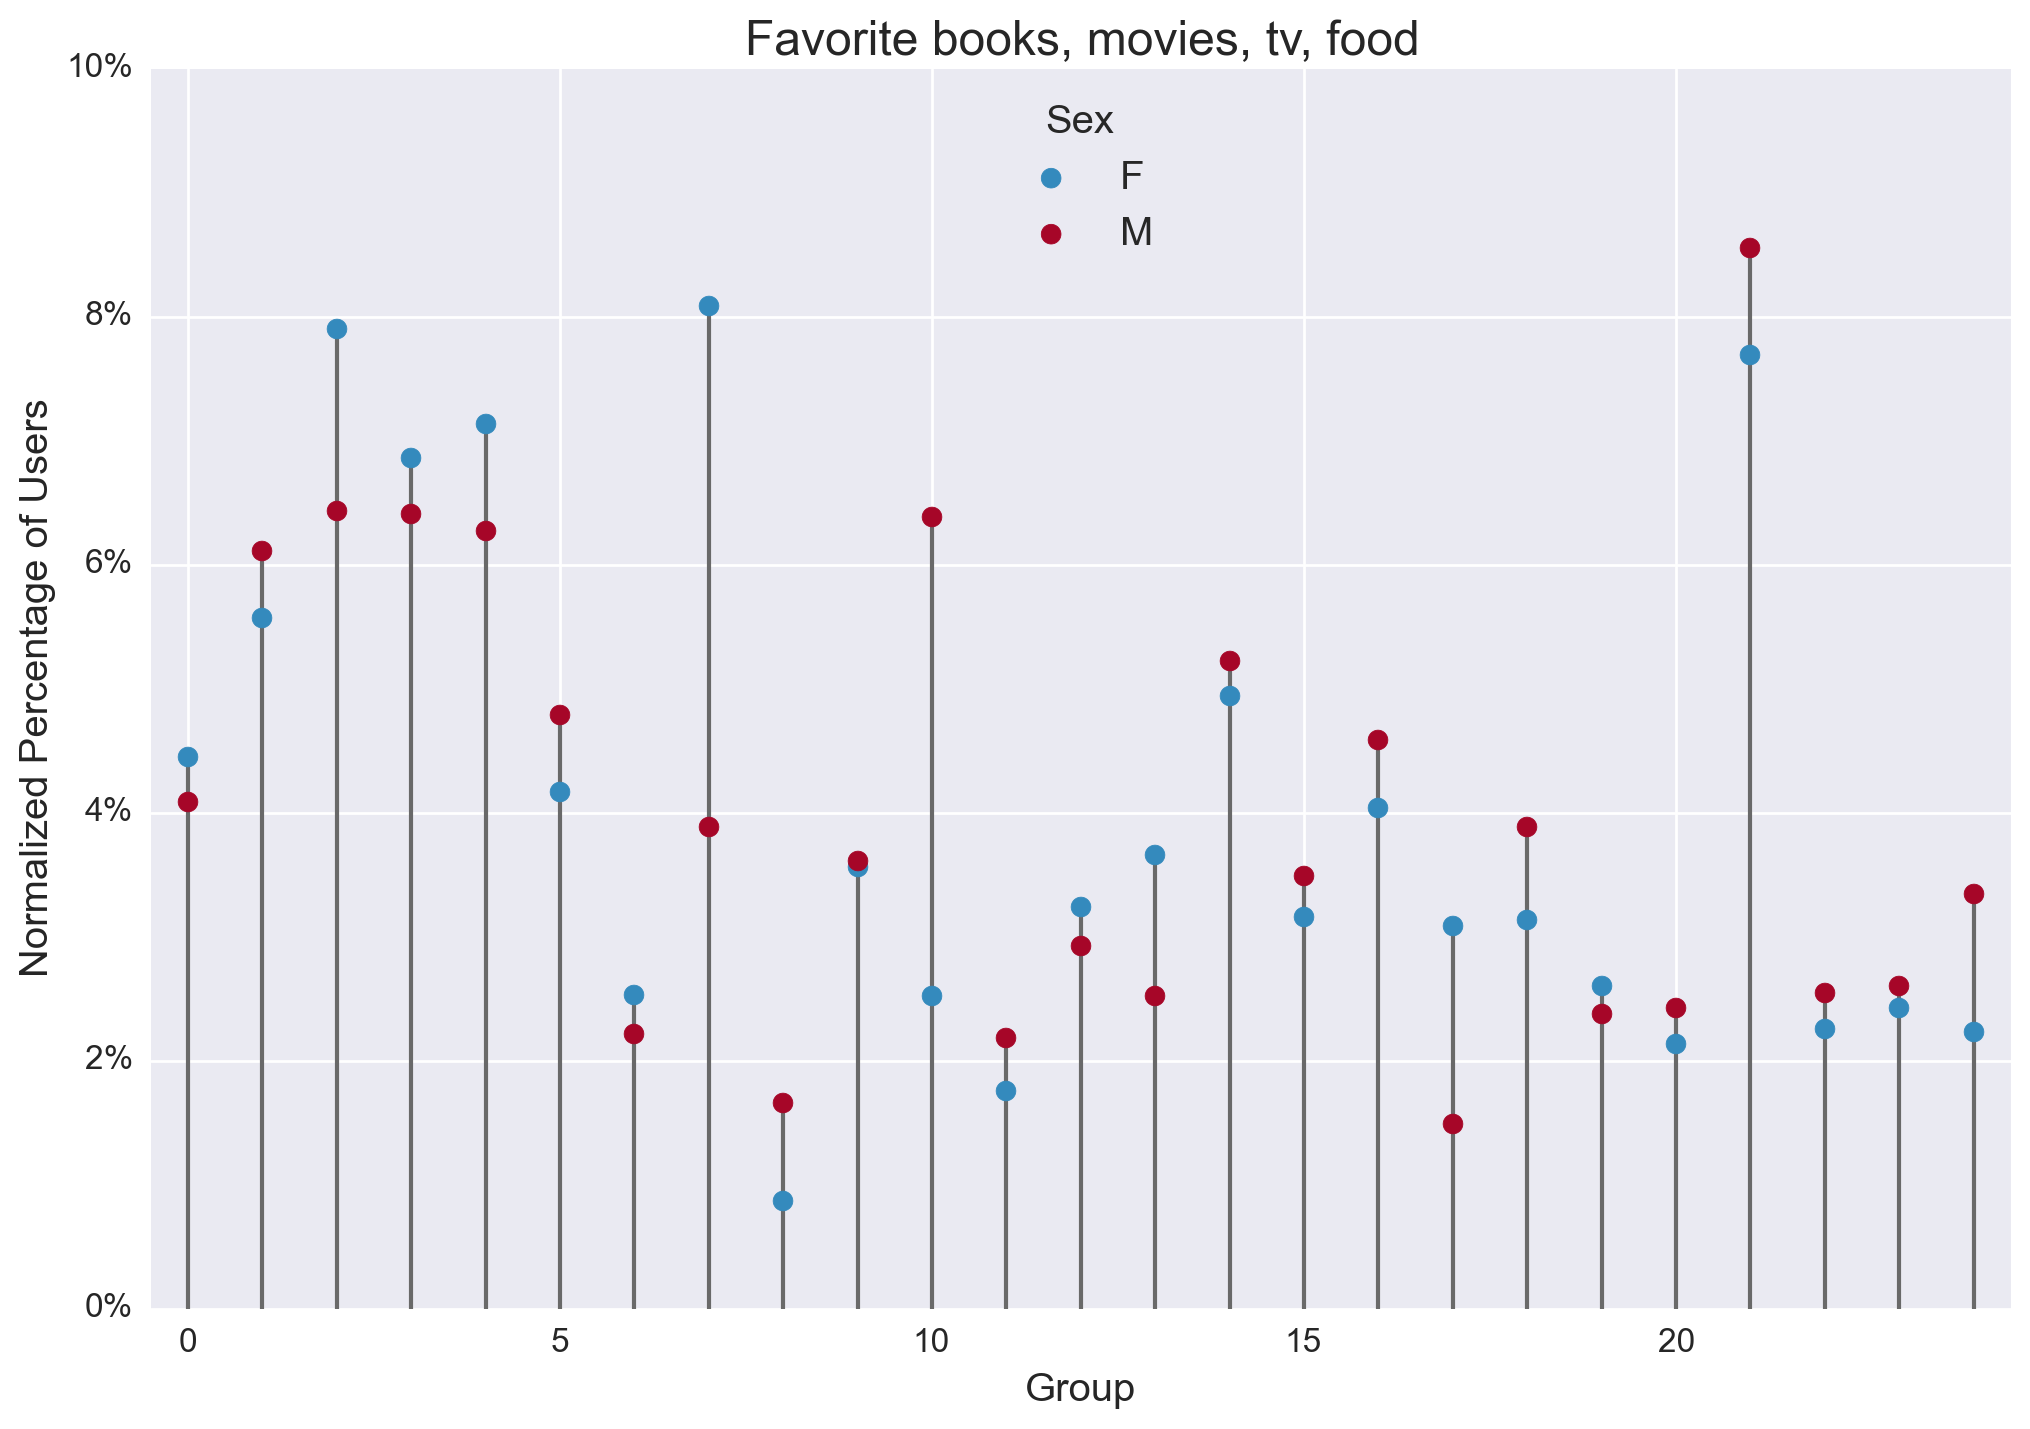

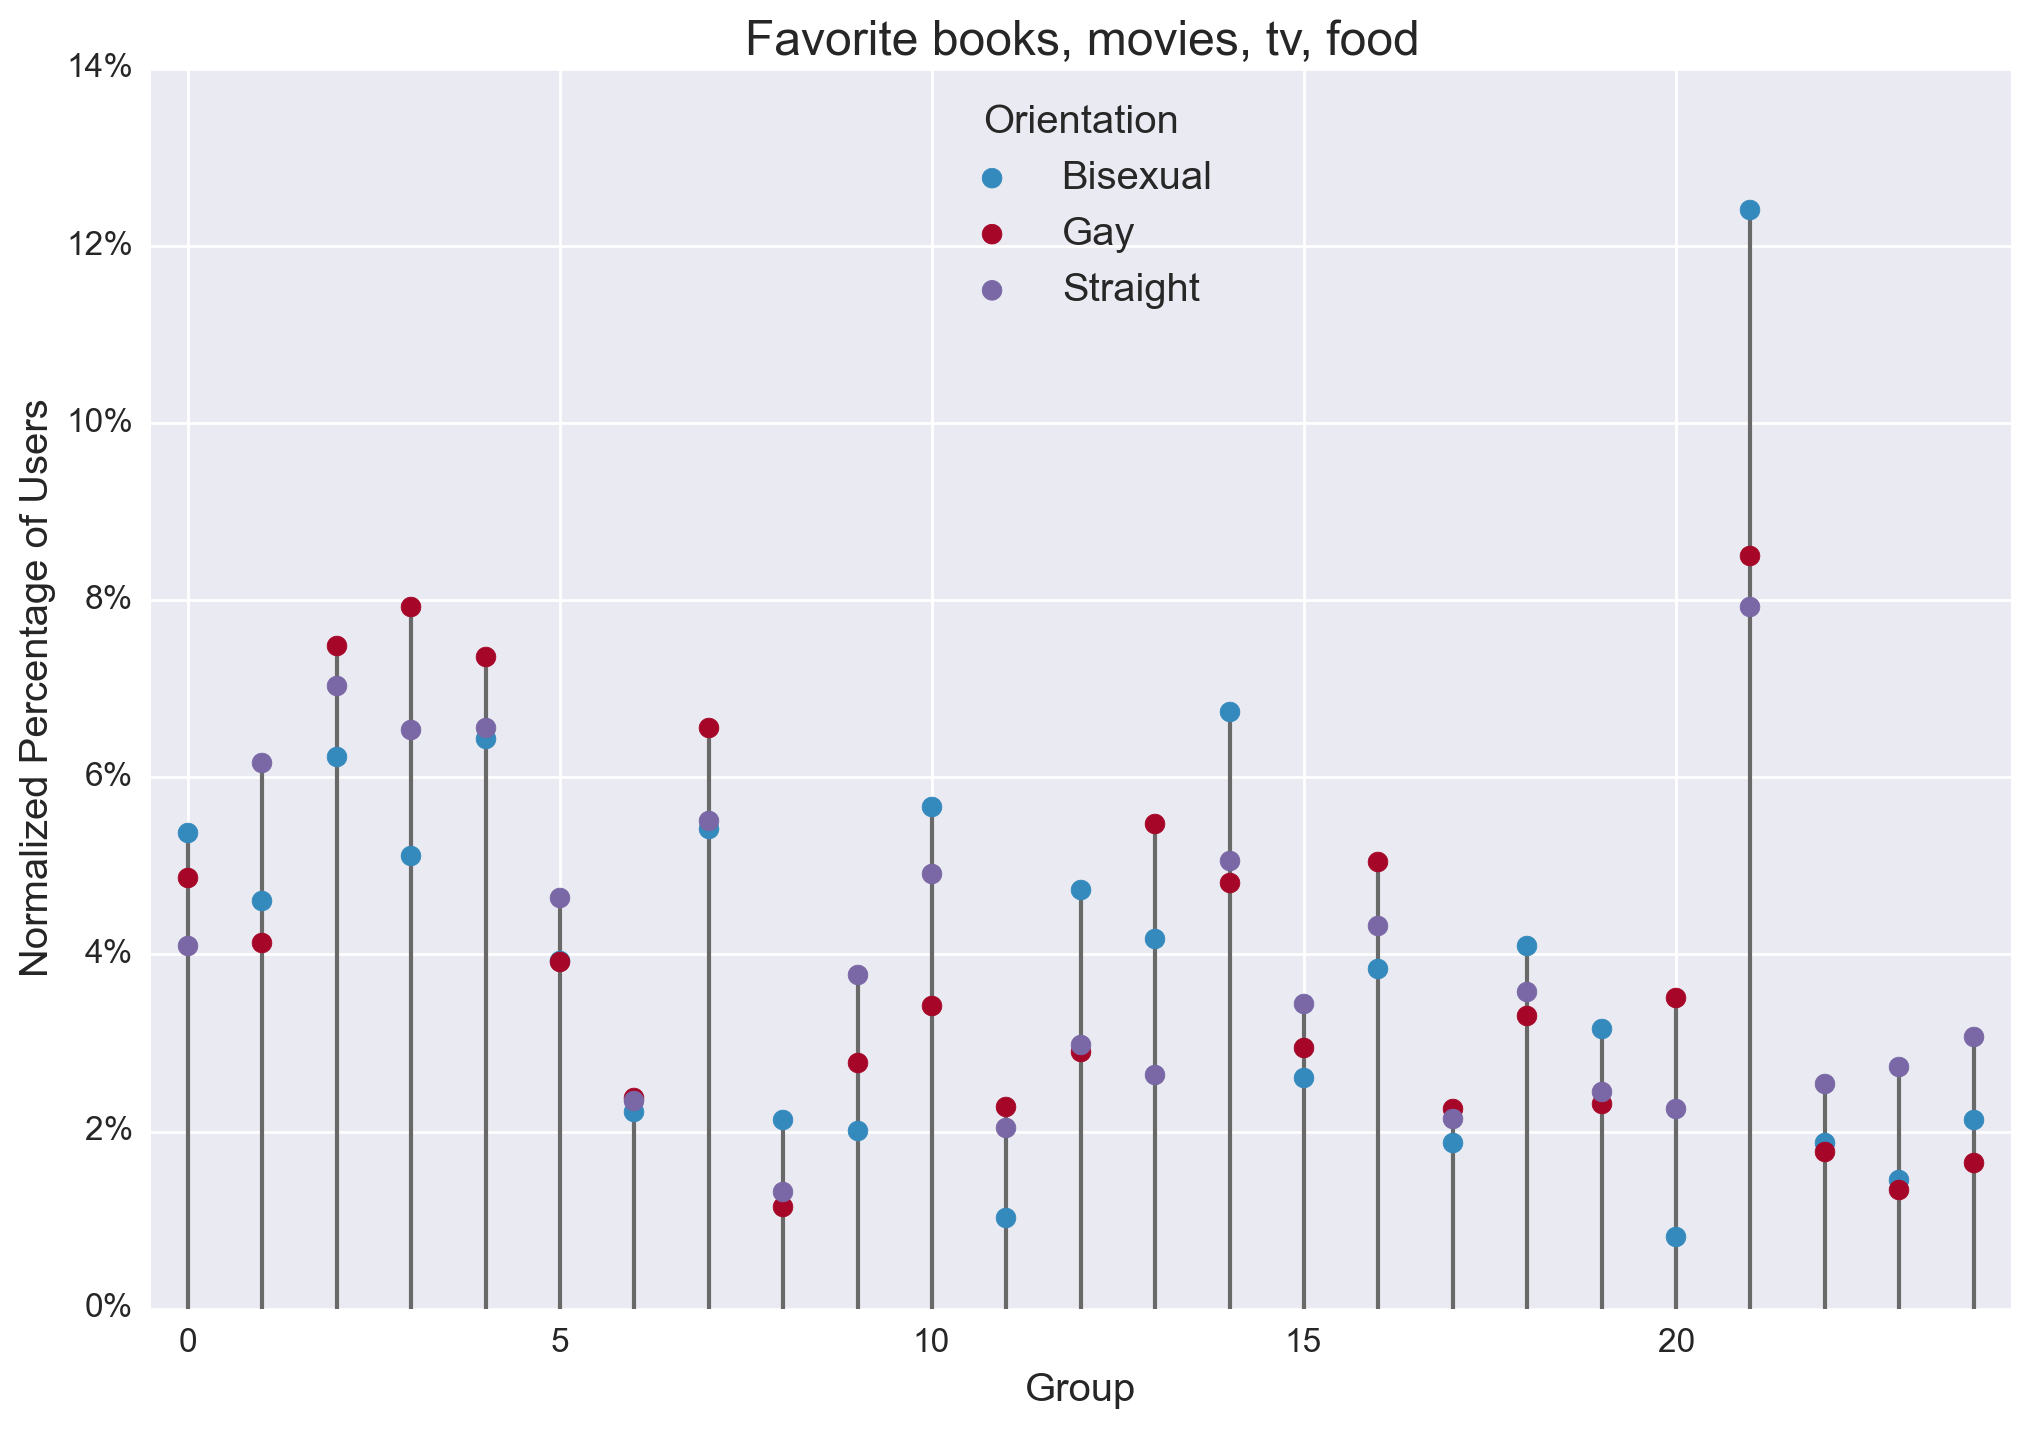

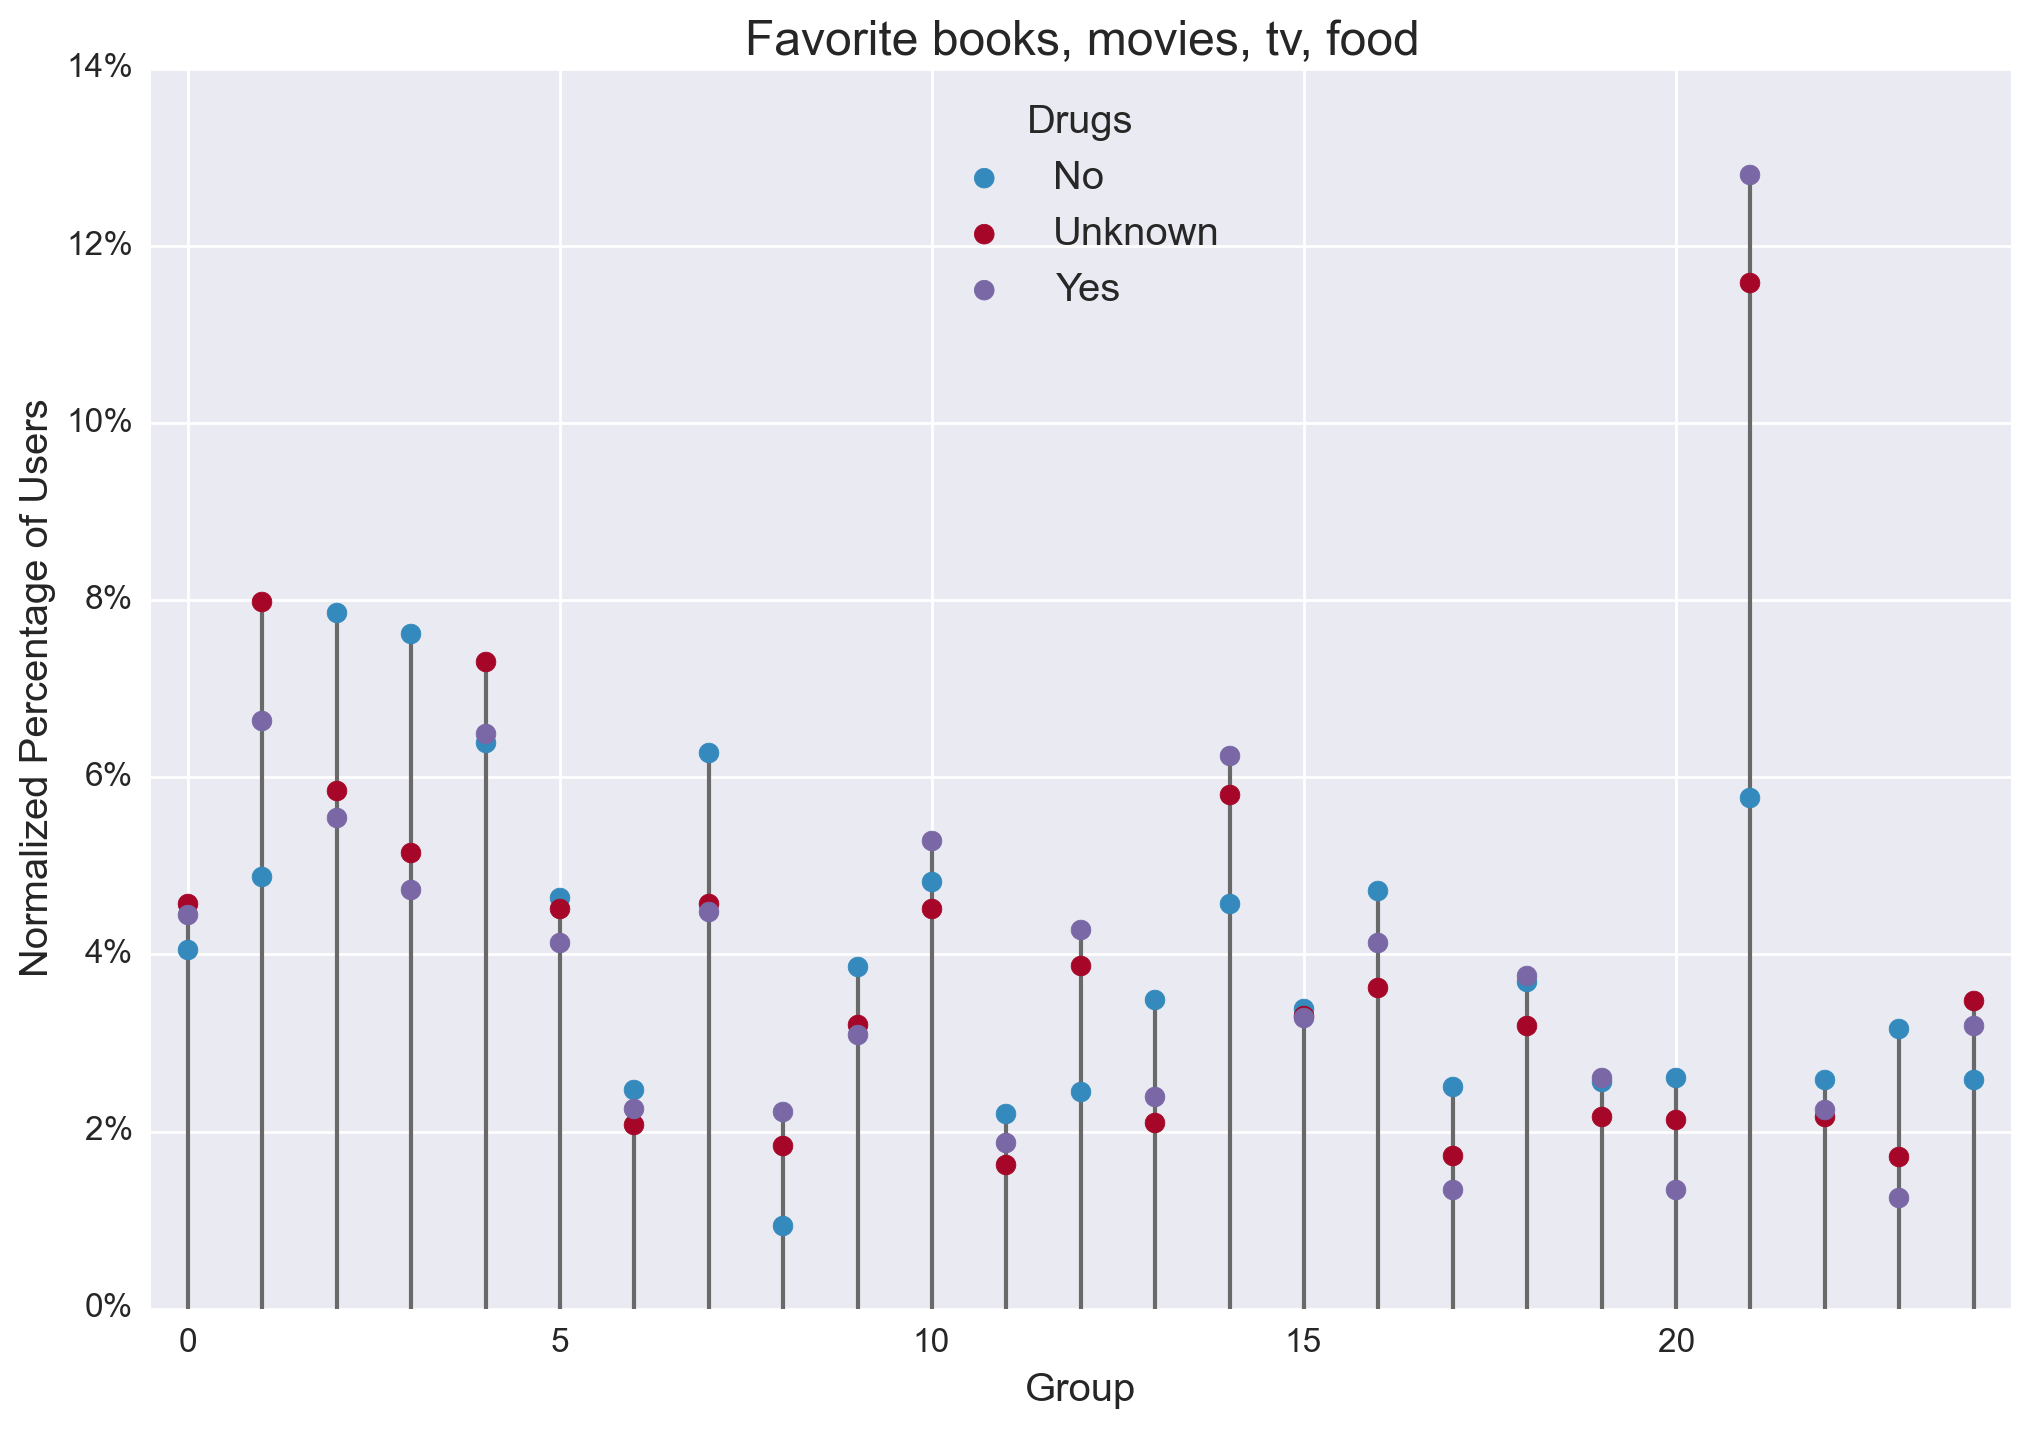

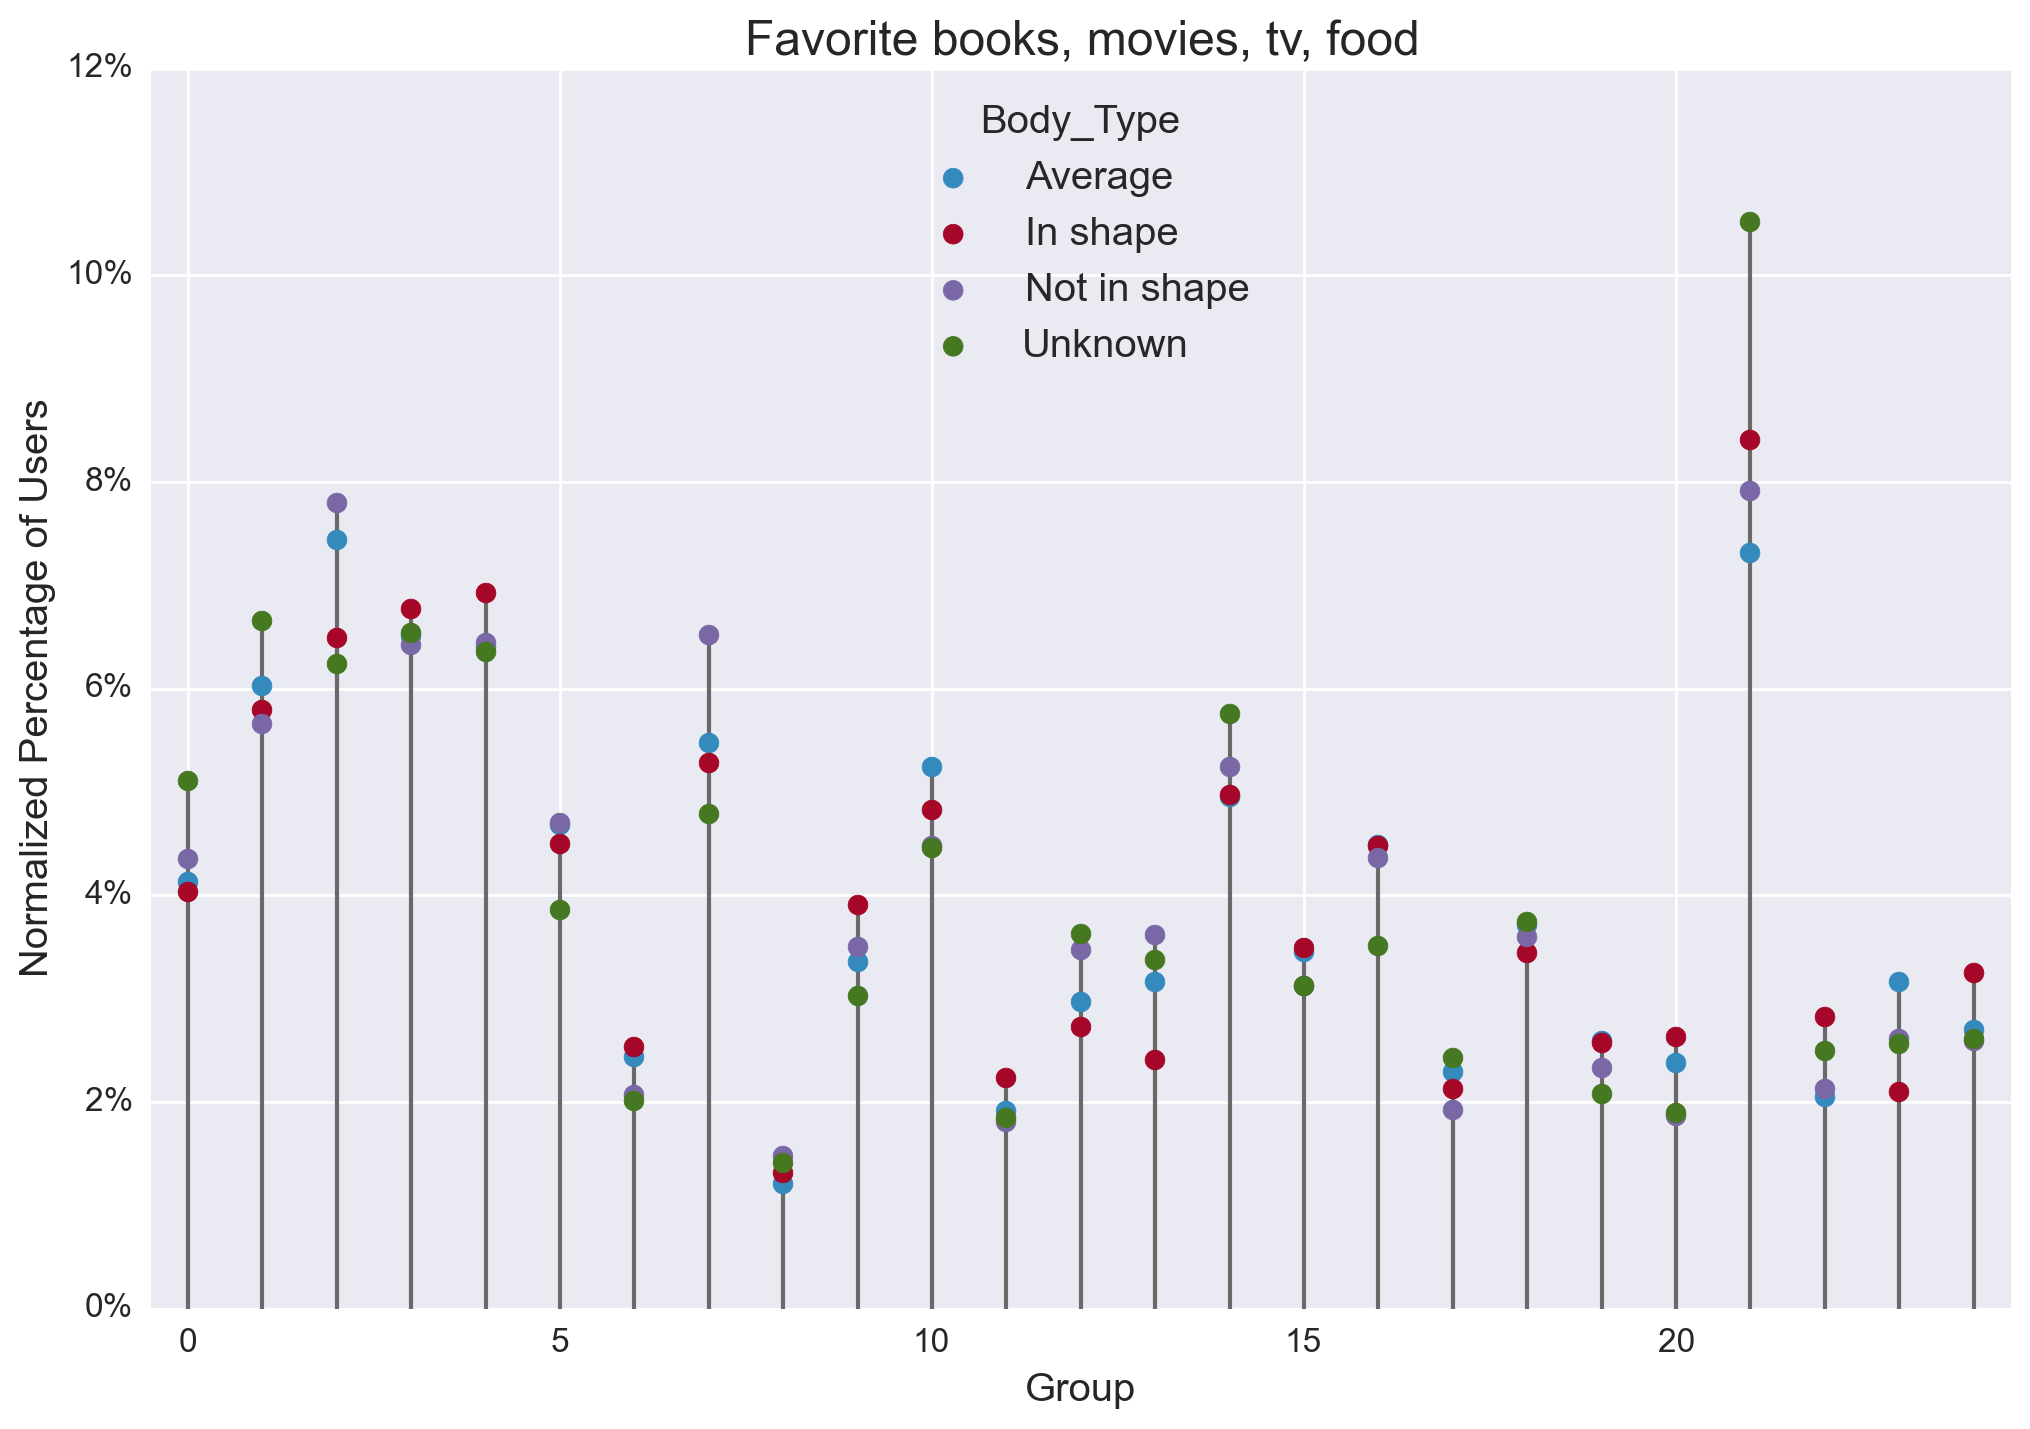

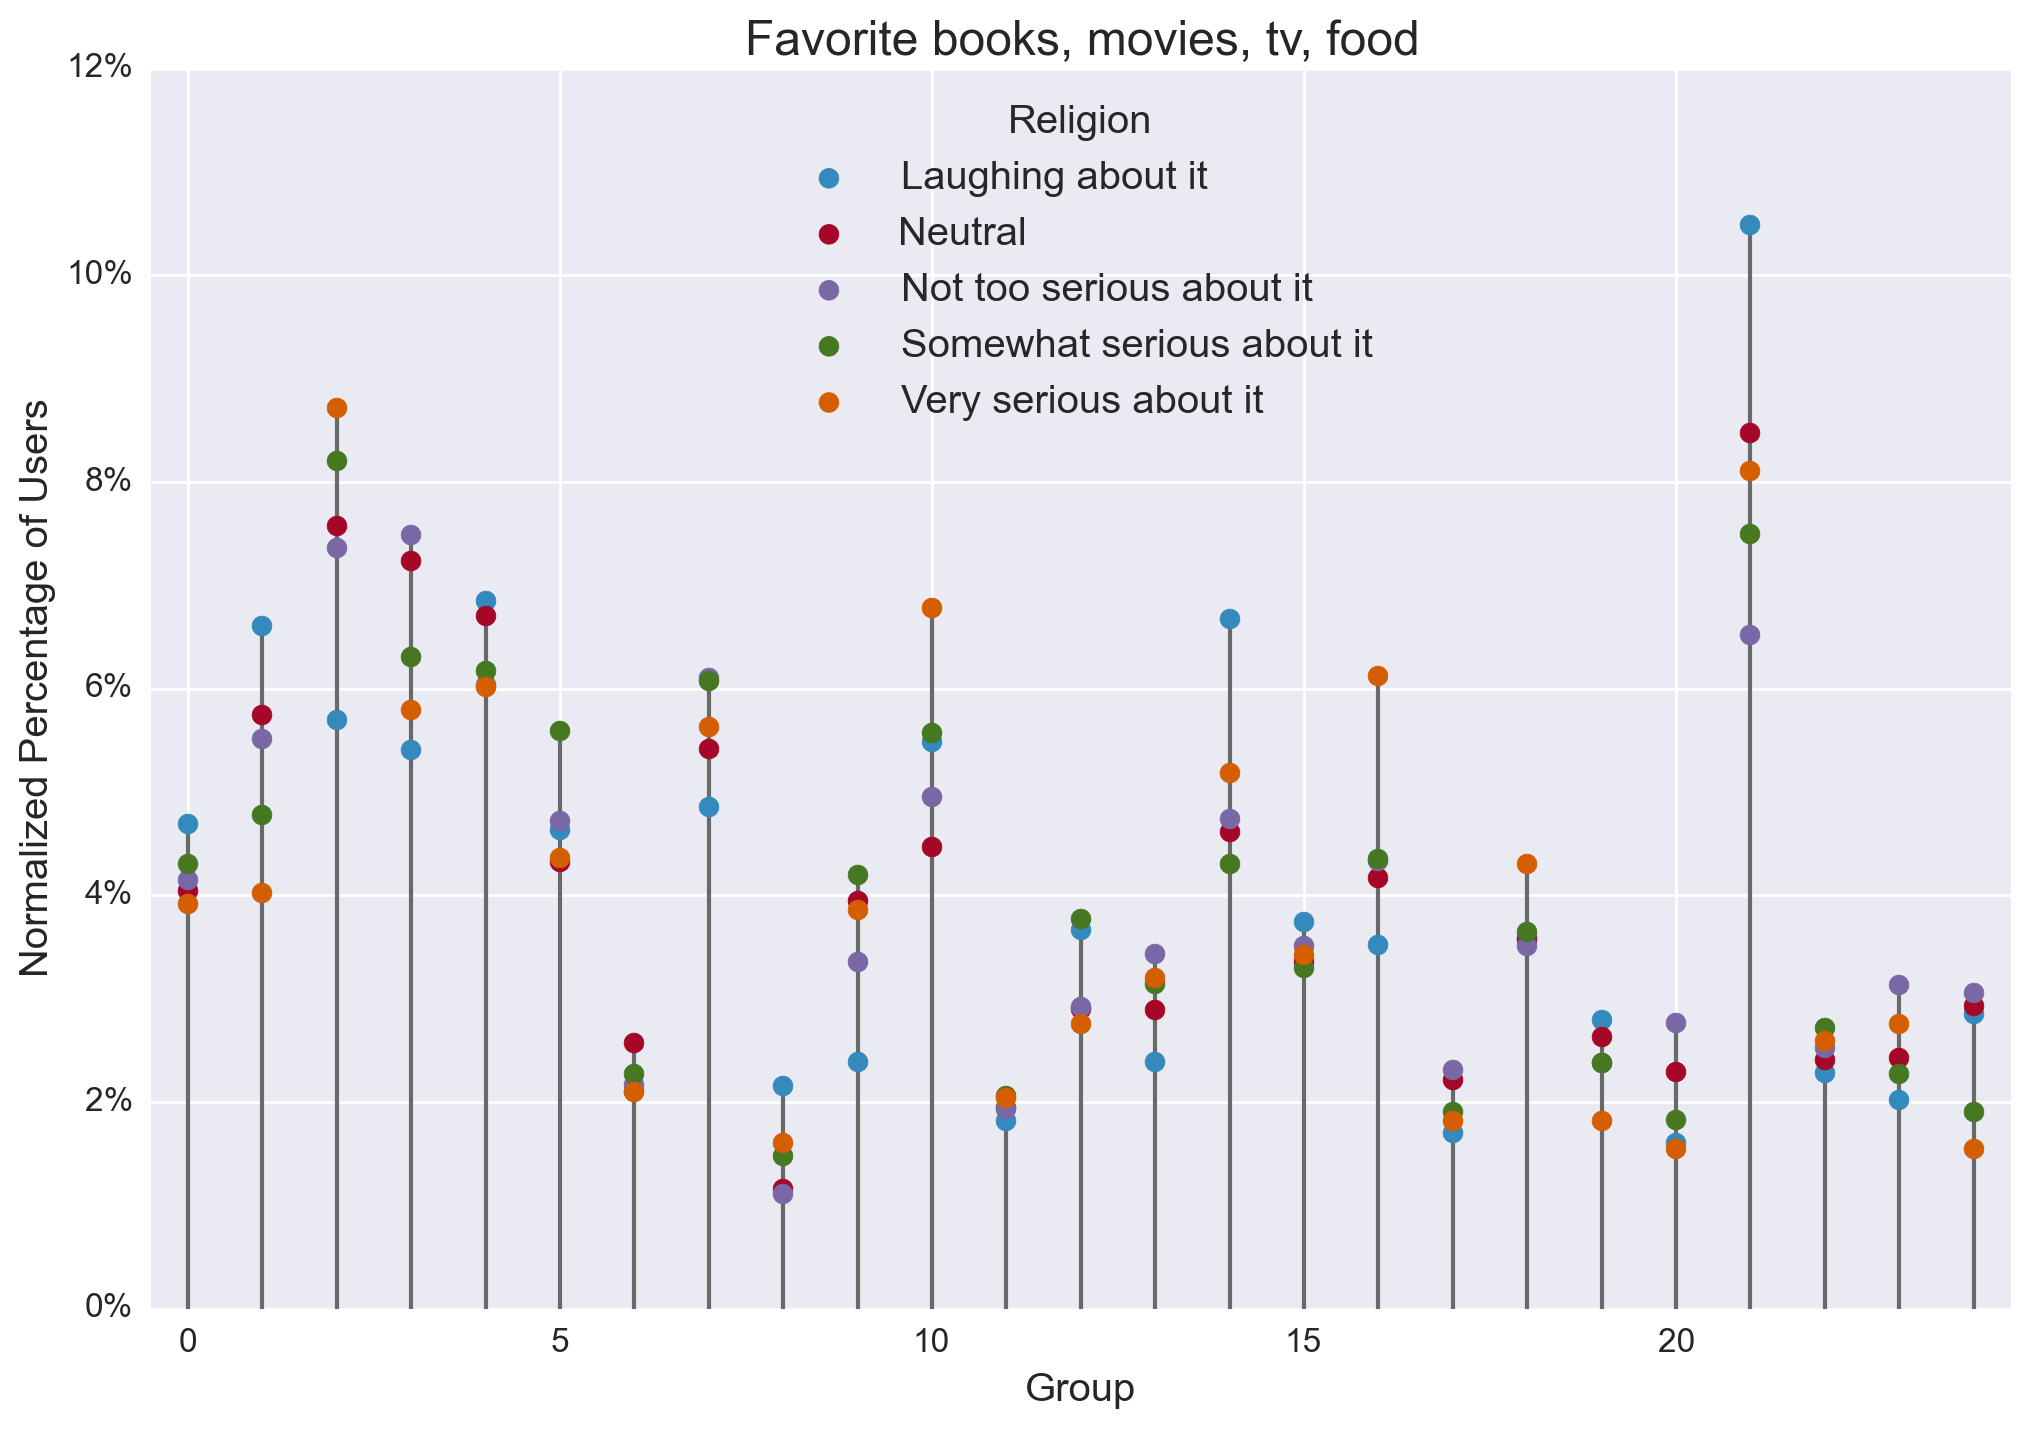

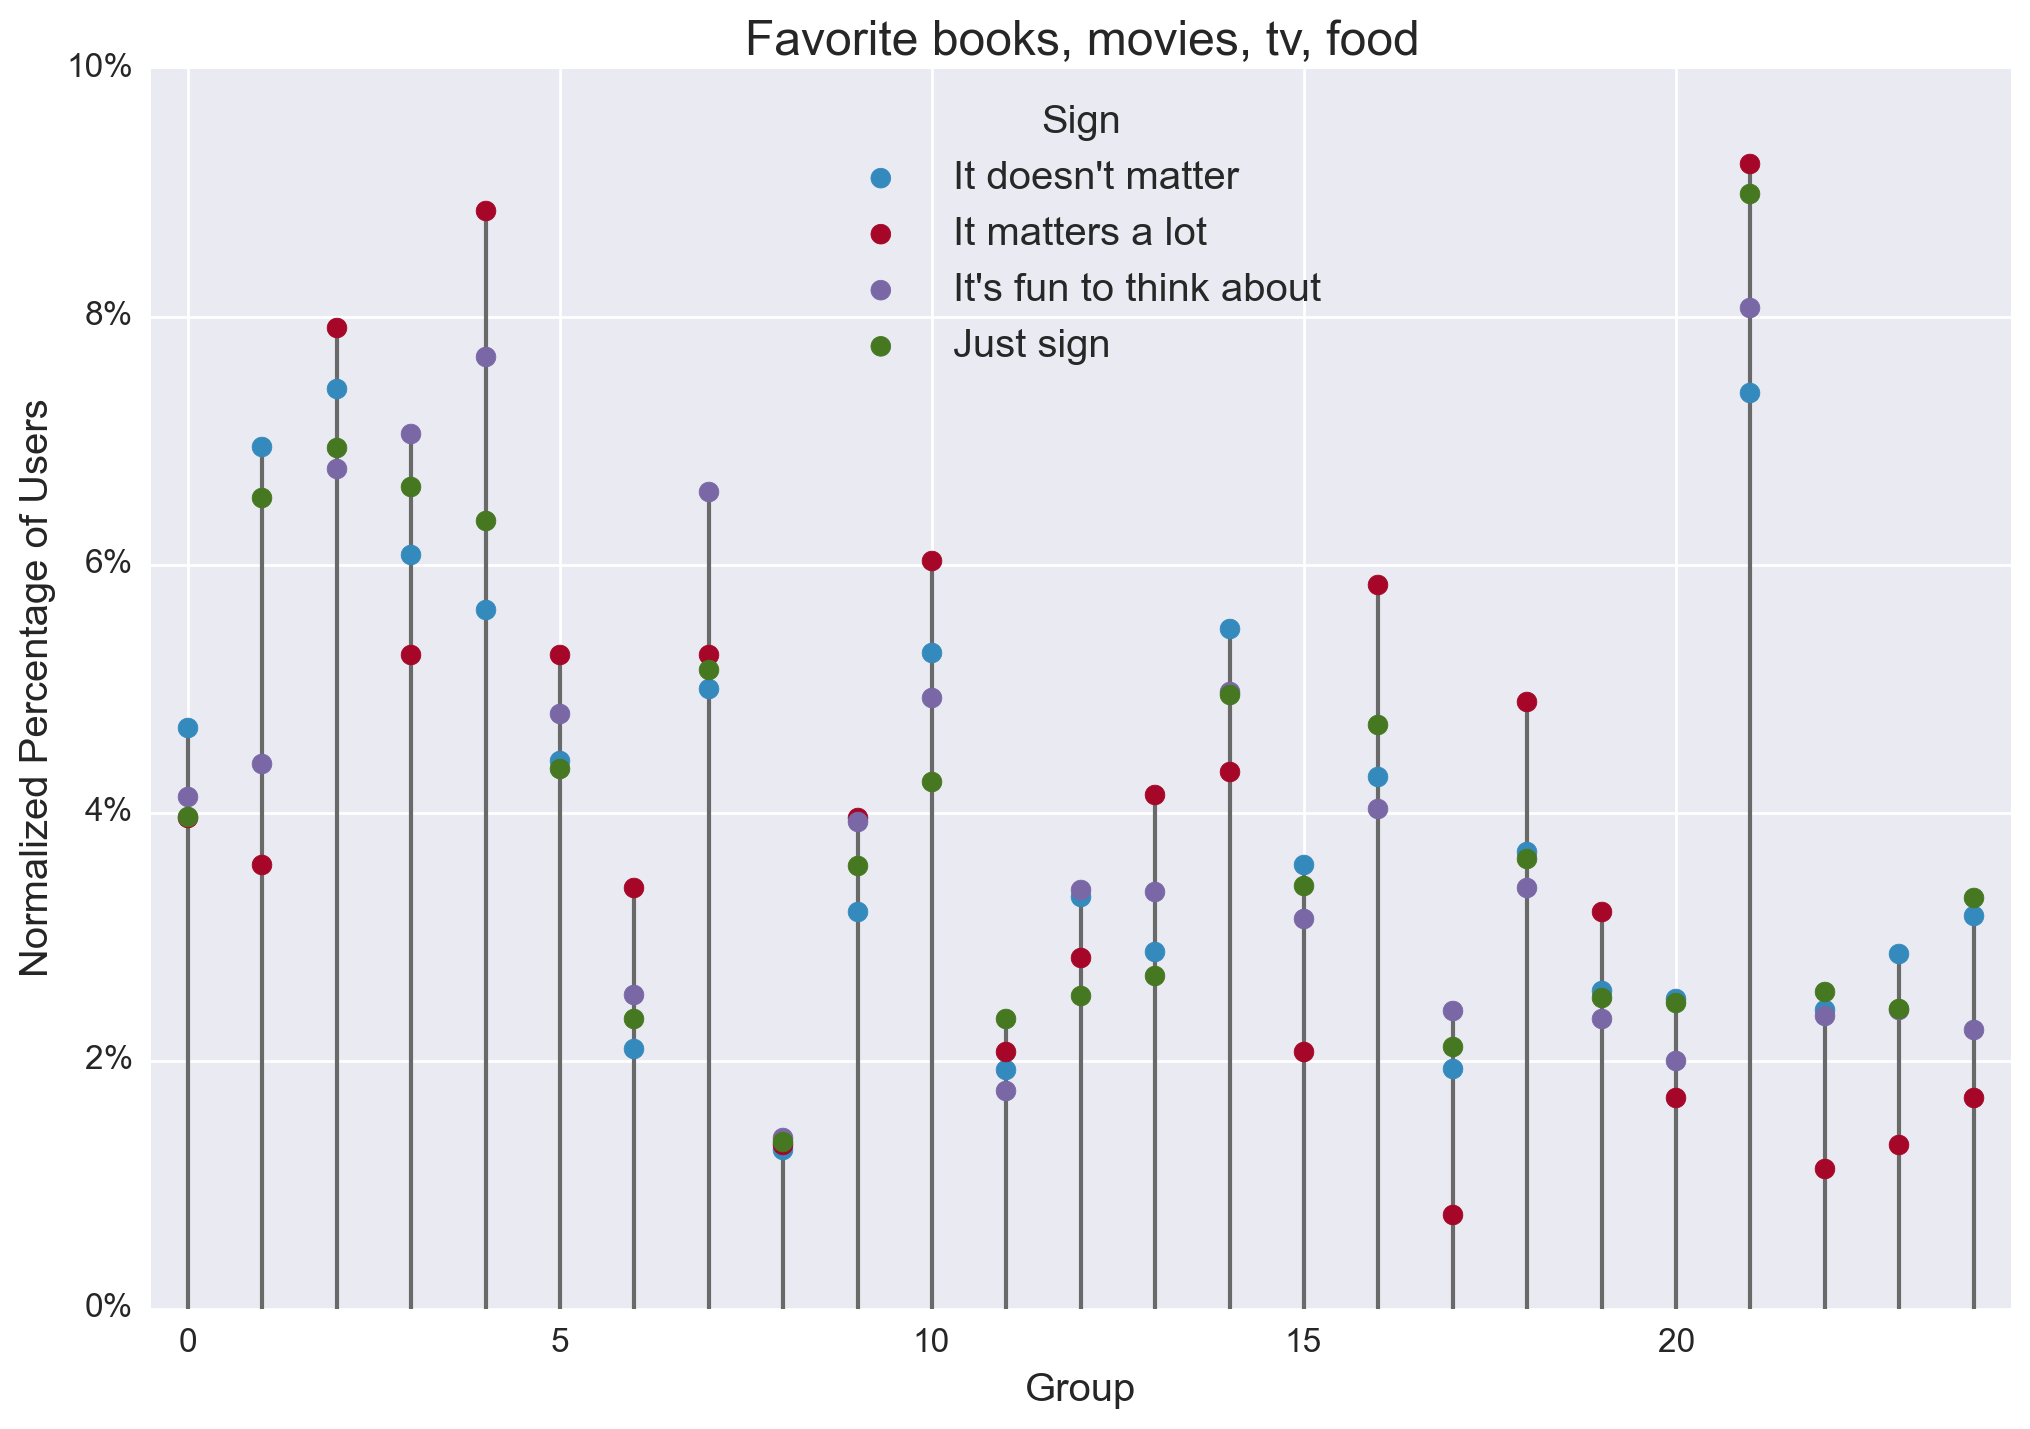

In [20]:
for demog in ['sex', 'orientation', 'drugs', 'body_type', 'religion', 'sign']:
    this = pd.DataFrame({'count' :
                         df_clean.groupby([demog, 'group'])['group'].count()}).reset_index()
    that = this.groupby(demog, as_index=False)['count'].sum()
    this = pd.merge(this, that, on=demog)
    this['pct'] = this.count_x / this.count_y

    plt.figure(figsize=(12, 8))
    
    # lines
    lineval = this.groupby('group')['pct'].max()
    for i, g in enumerate(lineval):
        plt.plot([i, i], [0, g],
                 linewidth=1.5,
                 color='DimGray',
                 zorder=1)

    # markers
    for i, d in enumerate(this[demog].unique()):
        tdf = this[this[demog]==d]
        plt.scatter(range(len(tdf)), tdf.pct,
                    s=50,
                    color=colors[i],
                    zorder=2, label=d.capitalize())
    
    plt.xlim(-0.5, len(tdf)-0.5)
    plt.ylim(0)
    
    plt.gca().get_yaxis().set_major_formatter(
                mpl.ticker.FuncFormatter(lambda y, p: format(y, '.0%'))
            )

    plt.xlabel('Group')
    plt.ylabel('Normalized Percentage of Users')

    plt.title(essay_dict[essay_list[0]])
    lg = plt.legend(title=demog.title(), loc=9)
    lg.get_title().set_fontsize('x-large')

### Sex

In [15]:
count_m7 = count_matrix[np.array((df_clean.group==7)&(df_clean.sex=='m')), :]
count_f7 = count_matrix[np.array((df_clean.group==7)&(df_clean.sex=='f')), :]

In [16]:
blah = pd.DataFrame({'m' : np.array(count_m7.sum(axis=0))[0],
                     'f' : np.array(count_f7.sum(axis=0))[0],
                     'vocab' : vocab})

In [17]:
blah['f'] = blah.f / blah.f.sum()
blah['m'] = blah.m / blah.m.sum()

In [18]:
blah.sort('f', ascending=False, inplace=True)
blah.reset_index(drop=True, inplace=True)

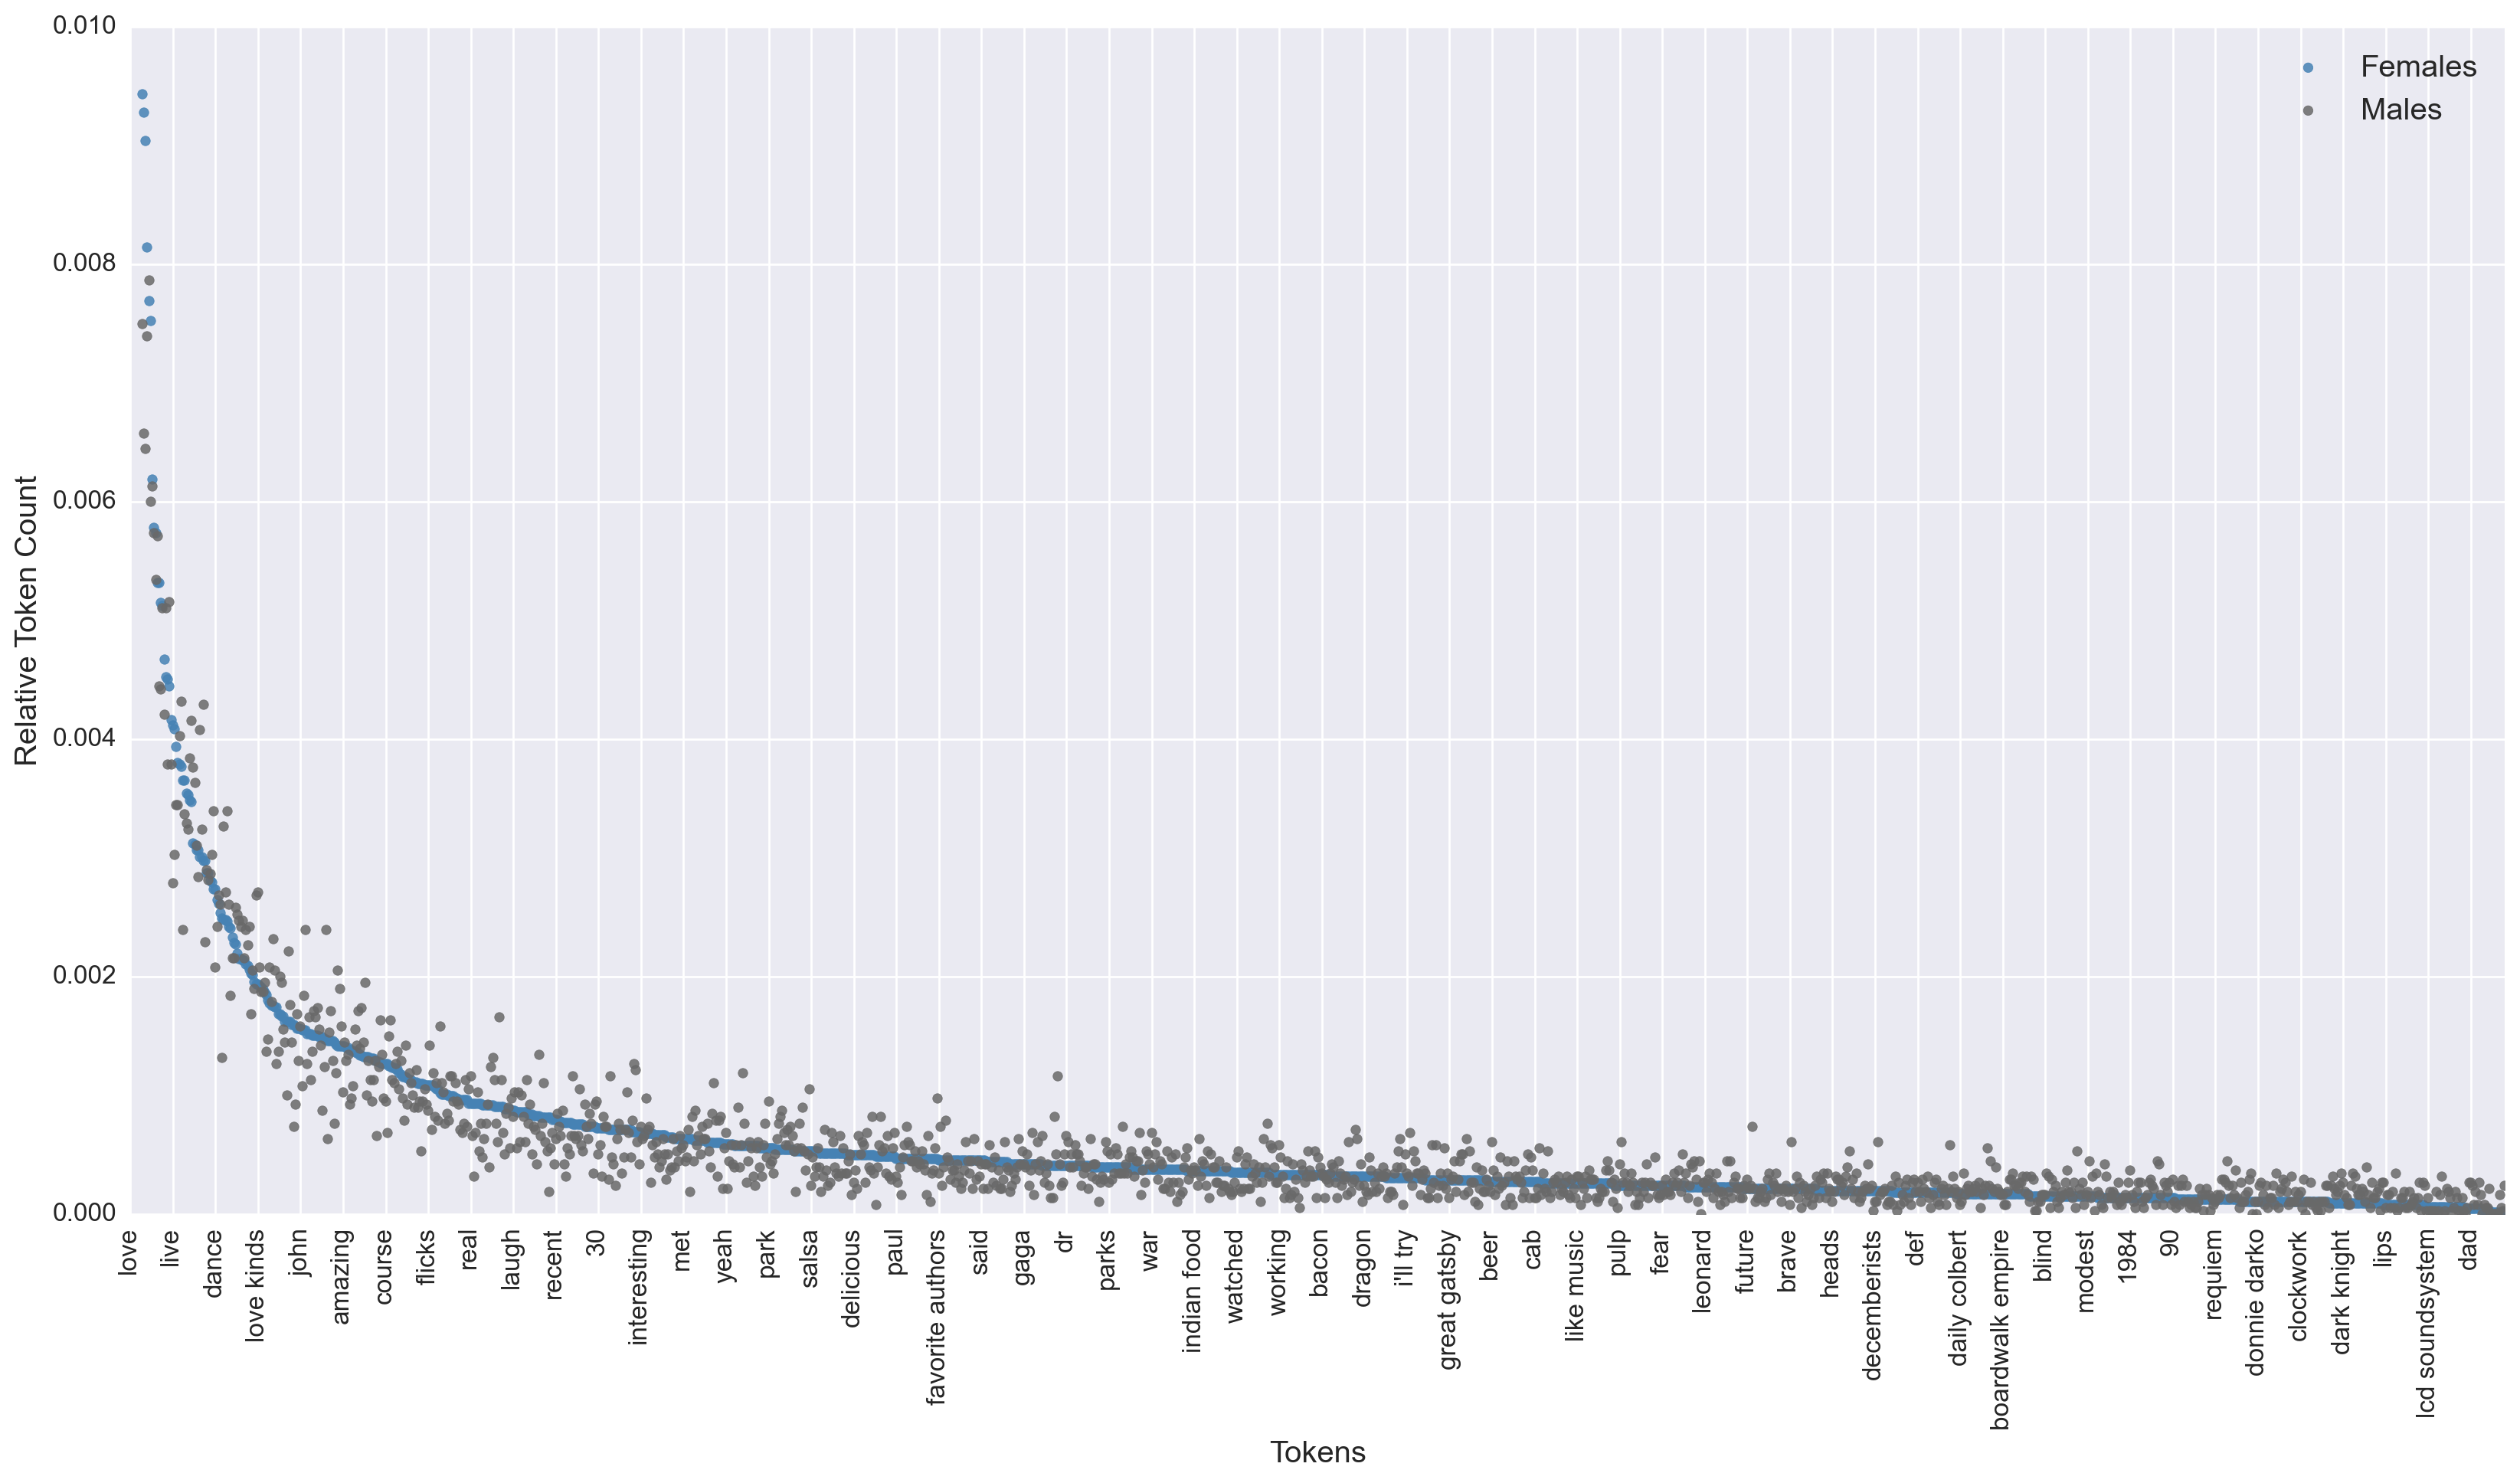

In [19]:
plt.figure(figsize=(20, 10))

plt.scatter(blah.index, blah.f, alpha=0.85, color='SteelBlue', label='Females')
plt.scatter(blah.index, blah.m, alpha=0.85, color='DimGray', label='Males')

plt.xticks(blah.index[::25].tolist(), blah.vocab[::25].tolist(), rotation=90);

plt.xlabel('Tokens')
plt.ylabel('Relative Token Count')

plt.xlim(0, blah.index.max());
plt.ylim(0, 0.01)

plt.legend()